In [1]:
import numpy as np
import pandas as pd
from fuzzywuzzy import fuzz, process
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm

C:\Users\wangt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
%pip install seaborn

  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
Note: you may need to restart the kernel to use updated packages.


Error processing line 3 of C:\Users\wangt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\googleapis_common_protos-1.56.0-py3.10-nspkg.pth:

  Traceback (most recent call last):
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.2800.0_x64__qbz5n2kfra8p0\lib\site.py", line 186, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 568, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
df = pd.read_csv('./clean_train2.csv')
df = df.dropna()
print(df['is_duplicate'].value_counts())
qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Total Questions',qid.shape[0])
print('Unique questions',np.unique(qid).shape[0])

1    149263
0    149250
Name: is_duplicate, dtype: int64
Total Questions 597026
Unique questions 390725


In [18]:
#total words in questions
df['total_words_q1'] = (df['clean_q1']).str.split().str.len()
df['total_words_q2'] = df['clean_q2'].str.split().str.len()

#number of common words
def common_words(row):
    return len(set(map(lambda word: word.lower().strip(), row['clean_q1'].split(" ")))
             & set(map(lambda word: word.lower().strip(), row['clean_q2'].split(" ")))) 
df['num_common_words'] = df.apply(common_words, axis=1)

#percentage of common words / total unique words in both questions
df['common_words_percentage'] = df['num_common_words']/(df['total_words_q1'] + df['total_words_q2'] - df['num_common_words'])

In [ ]:
#adding fuzzywuzzy features, https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

#fuzz_ratio: calculates the string matching score using Levenschtein Distances
#fuzz_partial_ratio: calculates the partial string ratio between the smallest string against all the n length sub-string of the long string
#fuzz_token_set_ratio: calculates ratio on 3 different sub-string sets and returns the maximum ratio
#fuzz_token_sort_ratio: calculates the similarity ratio after sorting the tokens generated in each string

In [19]:
df['fuzz_ratio'] = df.apply(lambda x: fuzz.QRatio(x["clean_q1"], x["clean_q2"]), axis=1)

In [20]:
df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(x["clean_q1"], x["clean_q2"]), axis=1)

In [22]:
df['fuzz_token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(x["clean_q1"], x["clean_q2"]), axis=1)

In [23]:
df['fuzz_token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(x["clean_q1"], x["clean_q2"]), axis=1)

In [24]:
def additional_features(row):
    q1 = row['clean_q1']
    q2 = row['clean_q2']
    t1 = q1.split()
    t2 = q2.split()
    first_word_same = int(t1[0] == t2[0])
    last_word_same = int(t1[-1] == t2[-1])
    return first_word_same, last_word_same

add_features = df.apply(additional_features, axis=1)

df['first_word_same'] = list(map(lambda x: x[0], add_features))
df['last_word_same'] = list(map(lambda x: x[1], add_features))

In [25]:
df['length_difference'] = abs(df['total_words_q1'] - df['total_words_q2'])

In [33]:
#cosine similarity using TF-IDF (Term frequency-Inverse document frequency) vectorizer
#converts text into weighted vectors, dot product to measure cosine similarity
q = list(df['clean_q1'])+list(df['clean_q2'])
vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(q)
q1_vectors = x[: (x.shape[0]//2) , :]
q2_vectors = x[(x.shape[0]//2) : , :]

ques_pair_vectors=[]
for i in tqdm(range(q1_vectors.shape[0])):
    ques_pair_vectors.append(q1_vectors[i].dot(q2_vectors[i].T).toarray()[0][0]   )

df['cosine_similarity'] = ques_pair_vectors

100%|██████████| 298513/298513 [01:36<00:00, 3106.51it/s]


In [2]:
df.to_csv('final_dataset.csv', index=False)

NameError: name 'df' is not defined

In [8]:
df = pd.read_csv('final_dataset.csv')
df

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,clean_q1,clean_q2,total_words_q1,...,num_common_words,common_words_percentage,fuzz_ratio,fuzz_partial_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,first_word_same,last_word_same,length_difference,cosine_similarity
0,0,183287,280315,256544,What are some words that rhyme with home?,"What are some words that rhyme with ""on""?",0,word rhyme home,word rhyme on,3,...,2,0.500000,86,92,87,86,1,0,0,0.737321
1,1,142423,225865,225866,Is there a relationship between not having dip...,Did the loyalty of Indians towards their work ...,0,relationship dipole dipole force molecular str...,loyalty indian towards work reduce mncs entere...,9,...,0,0.000000,24,40,24,27,0,0,1,0.000000
2,2,52519,92973,92974,How are bodies of water named? And who gets to...,How does water in the ocean and sea evaporate?...,0,body water named get decide ex pacific ocean s...,water ocean sea evaporate temperature sun ray ...,11,...,3,0.150000,30,28,42,48,0,0,1,0.265837
3,3,195852,296412,296413,What is the average salary of front-end develo...,What is the average salary of a UI/UX designer...,0,average salary front end developer india,average salary ui ux designer front end develo...,6,...,6,0.666667,84,70,100,84,1,1,3,0.730334
4,4,63391,110328,110329,Will it be possible for an engineering backgro...,How do I prepare for entrance exams to pursue ...,0,possible engineering background student m a ph...,prepare entrance exam pursue m a mass communic...,14,...,6,0.333333,24,40,69,64,0,0,4,0.345218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298508,298521,404280,537922,537923,What are some outfit ideas to wear to a frat p...,What are some outfit ideas wear to a frat them...,1,outfit idea wear frat party,outfit idea wear frat themed party,5,...,5,0.833333,89,85,100,89,1,1,1,0.879316
298509,298522,404281,99131,81495,Why is Manaphy childish in Pokémon Ranger and ...,Why is Manaphy annoying in Pokemon ranger and ...,1,manaphy childish pokémon ranger temple sea,manaphy annoying pokemon ranger temple sea,6,...,4,0.500000,82,81,82,82,1,1,0,0.628363
298510,298523,404282,1931,16773,How does a long distance relationship work?,How are long distance relationships maintained?,1,long distance relationship work,long distance relationship maintained,4,...,3,0.600000,79,87,91,76,1,0,0,0.664121
298511,298524,404284,537926,537927,What does Jainism say about homosexuality?,What does Jainism say about Gays and Homosexua...,1,jainism say homosexuality,jainism say gay homosexuality,3,...,3,0.750000,93,84,100,93,1,1,1,0.897850


In [9]:
features = df.iloc[:,9:-1]
features

,total_words_q1,total_words_q2,num_common_words,common_words_percentage,fuzz_ratio,fuzz_partial_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,first_word_same,last_word_same,length_difference
0,3,3,2,0.500000,86,92,87,86,1,0,0
1,9,8,0,0.000000,24,40,24,27,0,0,1
2,11,12,3,0.150000,30,28,42,48,0,0,1
3,6,9,6,0.666667,84,70,100,84,1,1,3
4,14,10,6,0.333333,24,40,69,64,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...
298508,5,6,5,0.833333,89,85,100,89,1,1,1
298509,6,6,4,0.500000,82,81,82,82,1,1,0
298510,4,4,3,0.600000,79,87,91,76,1,0,0
298511,3,4,3,0.750000,93,84,100,93,1,1,1


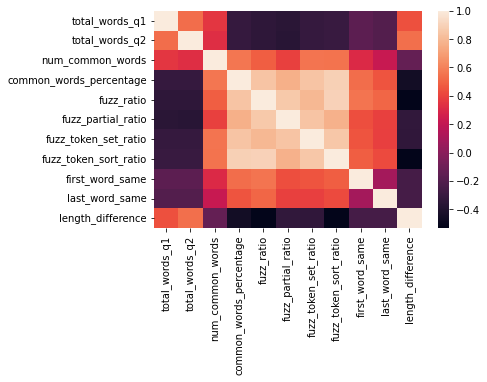

In [10]:
sns.heatmap(features.corr());

In [9]:
df.iloc[:,5:-1].describe()

,is_duplicate,total_words_q1,total_words_q2,num_common_words,common_words_percentage,fuzz_ratio,fuzz_partial_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,first_word_same,last_word_same,length_difference
count,298513.000000,298513.000000,298513.000000,298513.000000,298513.000000,298513.000000,298513.000000,298513.000000,298513.000000,298513.000000,298513.000000,298513.000000
mean,0.500022,5.540188,5.604543,2.798682,0.428681,62.233665,70.930928,76.982383,65.221317,0.393628,0.376587,1.842241
std,0.500001,3.014420,3.293314,1.697839,0.266179,22.301844,20.734665,22.165976,20.949802,0.488555,0.484531,2.459788
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.000000,3.000000,2.000000,0.230769,46.000000,56.000000,64.000000,51.000000,0.000000,0.000000,0.000000
50%,1.000000,5.000000,5.000000,3.000000,0.400000,63.000000,71.000000,82.000000,67.000000,0.000000,0.000000,1.000000
75%,1.000000,7.000000,7.000000,4.000000,0.600000,80.000000,88.000000,100.000000,81.000000,1.000000,1.000000,2.000000
max,1.000000,59.000000,106.000000,24.000000,1.000000,100.000000,100.000000,100.000000,100.000000,1.000000,1.000000,92.000000


In [8]:
#bag of words vectorization
vectorizer = CountVectorizer(stop_words="english", max_features=500)
questions_df = df[['clean_q1', 'clean_q2']]
questions = list(questions_df['clean_q1']) + list(questions_df['clean_q2'])
q1_arr, q2_arr = np.vsplit(vectorizer.fit_transform(questions).toarray(),2)
df1 = pd.DataFrame(q1_arr, index= questions_df.index)
df2 = pd.DataFrame(q2_arr, index= questions_df.index)

In [9]:
df1.to_csv('vectorized_q1.csv', index=False)
df2.to_csv('vectorized_q2.csv', index=False)

In [10]:
#sample code to using vectorization results using logistc regression

from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

df_q1 = pd.read_csv('./vectorized_q1.csv')
df_q2 = pd.read_csv('./vectorized_q2.csv')

q_vector = pd.concat([df_q1, df_q2], axis=1)

In [11]:
X_train,X_test,y_train,y_test = train_test_split(q_vector,df['is_duplicate'],test_size=0.2,random_state=1)
lr = LogisticRegression(max_iter=500)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
accuracy_score(y_test,y_pred)

0.6499673383247073

In [ ]:
#sample code for lemmatization 
#use a sample of the full dataset to train & test this

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

def pos_text(text):
    tokens = nltk.word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

#function to get the POS tag of a token
def get_wordnet_pos(token):
    tag = nltk.pos_tag([token])[0][1][0].upper()
    tag_dict = {'J': wordnet.ADJ,
                'N': wordnet.NOUN,
                'V': wordnet.VERB,
                'R': wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

#sample usage:
#df['PoSTagged'] = df['question1'].apply(pos_text)